In [13]:
import pandas as pd
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

In [29]:
data = pd.read_csv("data/data-01011992-04062022.csv", encoding = "cp1252", decimal=',', thousands='.', parse_dates=['Tarih'],infer_datetime_format="%d.%m.%Y")
df = data.copy()
df.columns = ["Date", "Hour", "MWh"]

# Create datetime
df["Datetime"] = df.apply(lambda x: str(x["Date"].date()) + " " + x["Hour"], axis=1)
df["Datetime"] = pd.to_datetime(df["Datetime"], format='%Y-%m-%d %H:%M')
df = df[["Datetime", "MWh"]].copy()

In [30]:
data.tail()

Tarih   Saat  Tüketim Miktarý (MWh)
56344 2022-06-04  16:00               38998.94
56345 2022-06-04  17:00               38090.40
56346 2022-06-04  18:00               36493.34
56347 2022-06-04  19:00               35270.81
56348 2022-06-04  20:00               34064.91

In [31]:
df = df.set_index("Datetime",drop=True)

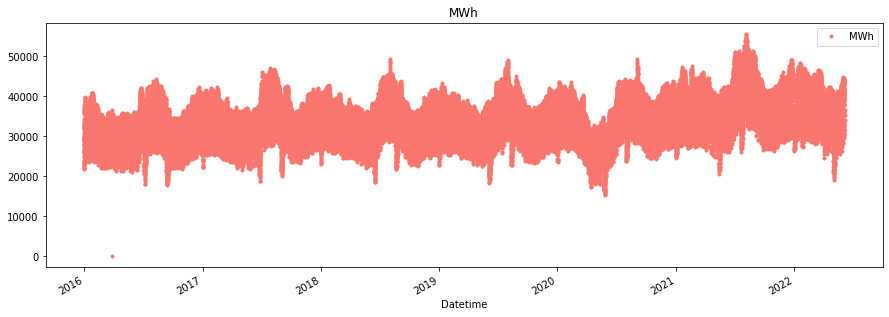

In [32]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='MWh')

In [33]:
df.index.min(), df.index.max()

(Timestamp('2015-12-31 00:00:00'), Timestamp('2022-06-04 20:00:00'))

In [34]:
split_date = '2022-01-01'

df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

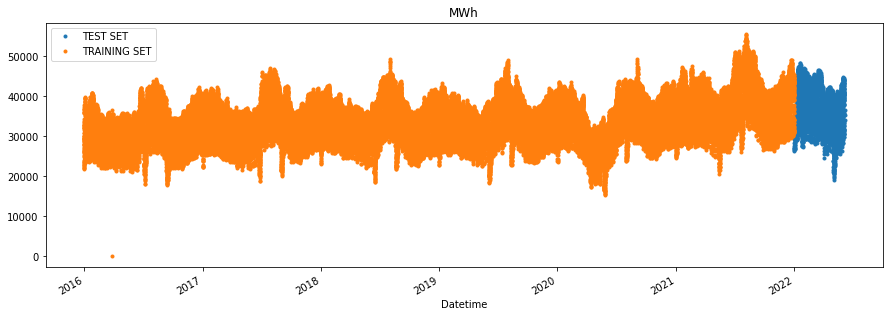

In [35]:
df_test.rename(columns={'MWh': 'TEST SET'}) \
    .join(df_train.rename(columns={'MWh': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='MWh', style='.');

In [36]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['6_hrs_lag'] = df['MWh'].shift(6)
    df['12_hrs_lag'] = df['MWh'].shift(12)
    df['24_hrs_lag'] = df['MWh'].shift(24)
    df['6_hrs_mean'] = df['MWh'].rolling(window = 6).mean()
    df['12_hrs_mean'] = df['MWh'].rolling(window = 12).mean()
    df['24_hrs_mean'] = df['MWh'].rolling(window = 24).mean()
    df['6_hrs_std'] = df['MWh'].rolling(window = 6).std()
    df['12_hrs_std'] = df['MWh'].rolling(window = 12).std()
    df['24_hrs_std'] = df['MWh'].rolling(window = 24).std()
    df['6_hrs_max'] = df['MWh'].rolling(window = 6).max()
    df['12_hrs_max'] = df['MWh'].rolling(window = 12).max()
    df['24_hrs_max'] = df['MWh'].rolling(window = 24).max()
    df['6_hrs_min'] = df['MWh'].rolling(window = 6).min()
    df['12_hrs_min'] = df['MWh'].rolling(window = 12).min()
    df['24_hrs_min'] = df['MWh'].rolling(window = 24).min()
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear' , '6_hrs_lag' , '24_hrs_lag' , '6_hrs_mean',
           "12_hrs_mean" ,"24_hrs_mean" ,"6_hrs_std" ,"12_hrs_std" ,"24_hrs_std",
           "6_hrs_max","12_hrs_max" ,"24_hrs_max" ,"6_hrs_min","12_hrs_min" ,"24_hrs_min"]]
    if label:
        y = df[label]
        return X, y
    return X

In [37]:
X, y = create_features(df, label='MWh')
features_and_target = pd.concat([X, y], axis=1)

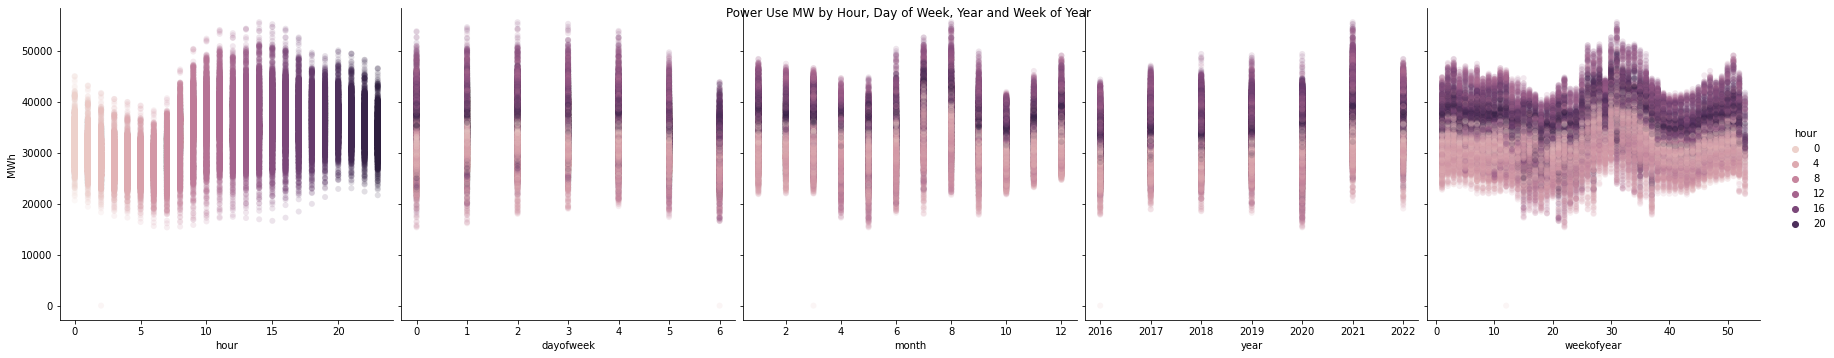

In [38]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek', 'month',
                     'year','weekofyear'],
             y_vars='MWh',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [39]:
df_2021 = df.loc[(df.index>='2021-01-01') & (df.index<'2022-01-01')]

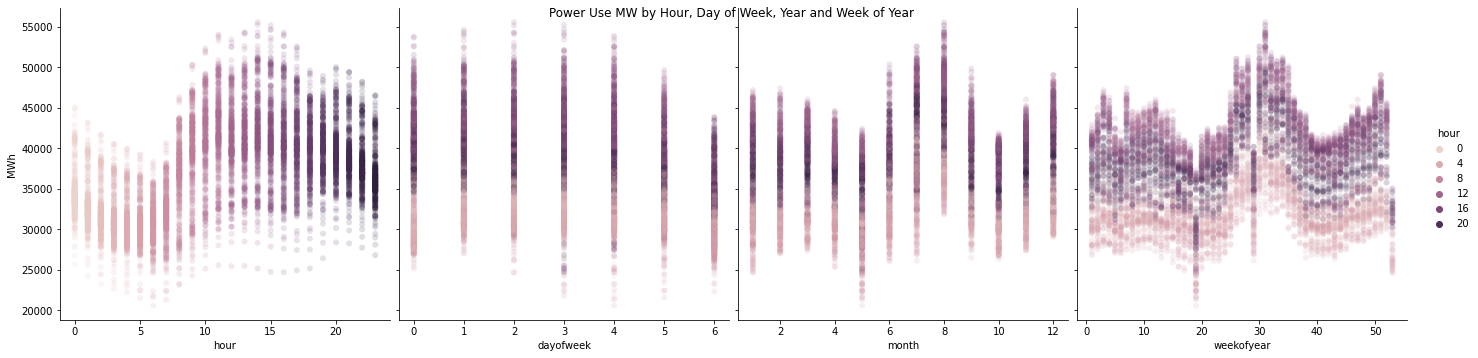

In [40]:
sns.pairplot(df_2021.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek','month','weekofyear'],
             y_vars='MWh',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [41]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'vscode' # or 'notebook' or 'colab' or 'jupyterlab'
fig = px.line(df, x=df.index, y='MWh', title='Time Series with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.update_layout(title='Electricity Consumption in Turkey from 2016')
fig.update_layout(height=1000)
fig.show()

In [43]:
import holidays

In [44]:
tr_holidays = holidays.TR()
tr_holidays.get('2021-05-13')

'Ramadan Feast'

In [45]:
for holiday in holidays.Turkey(years=[2016, 2017, 2018, 2019, 2020, 2021, 2022]).items():
    print(holiday)

(datetime.date(2016, 1, 1), "New Year's Day")
(datetime.date(2016, 4, 23), "National Sovereignty and Children's Day")
(datetime.date(2016, 5, 1), 'Labour Day')
(datetime.date(2016, 5, 19), 'Commemoration of Ataturk, Youth and Sports Day')
(datetime.date(2016, 8, 30), 'Victory Day')
(datetime.date(2016, 10, 29), 'Republic Day')
(datetime.date(2016, 7, 6), 'Ramadan Feast')
(datetime.date(2016, 7, 7), 'Ramadan Feast Holiday')
(datetime.date(2016, 7, 8), 'Ramadan Feast Holiday')
(datetime.date(2016, 9, 11), 'Sacrifice Feast')
(datetime.date(2016, 9, 12), 'Sacrifice Feast Holiday')
(datetime.date(2016, 9, 13), 'Sacrifice Feast Holiday')
(datetime.date(2016, 9, 14), 'Sacrifice Feast Holiday')
(datetime.date(2017, 1, 1), "New Year's Day")
(datetime.date(2017, 4, 23), "National Sovereignty and Children's Day")
(datetime.date(2017, 5, 1), 'Labour Day')
(datetime.date(2017, 5, 19), 'Commemoration of Ataturk, Youth and Sports Day')
(datetime.date(2017, 7, 15), 'Democracy and National Unity Day')


In [46]:
# Get all Turkish holiday dates from 2016
holiday_list = []
for holiday in holidays.Turkey(years=[2016, 2017, 2018, 2019, 2020, 2021, 2022]).items():
    holiday_list.append(holiday)

holidays_df = pd.DataFrame(holiday_list, columns=["date", "holiday"])
holidays_df

date                                         holiday
0   2016-01-01                                  New Year's Day
1   2016-04-23         National Sovereignty and Children's Day
2   2016-05-01                                      Labour Day
3   2016-05-19  Commemoration of Ataturk, Youth and Sports Day
4   2016-08-30                                     Victory Day
..         ...                                             ...
92  2022-05-04                           Ramadan Feast Holiday
93  2022-07-09                                 Sacrifice Feast
94  2022-07-10                         Sacrifice Feast Holiday
95  2022-07-11                         Sacrifice Feast Holiday
96  2022-07-12                         Sacrifice Feast Holiday

[97 rows x 2 columns]

In [47]:
df["Date"]= df.index.date
df.loc[df['Date'].isin(holidays_df["date"]), "holiday"] = 1
df.holiday.fillna(0, inplace=True)
df["holiday"] = df["holiday"].astype("int")

In [48]:
df.loc[df["holiday"]==1]

MWh                date  hour  dayofweek  quarter  \
Datetime                                                                      
2016-01-01 00:00:00  26277.24 2016-01-01 00:00:00     0          4        1   
2016-01-01 01:00:00  24991.82 2016-01-01 01:00:00     1          4        1   
2016-01-01 02:00:00  23532.61 2016-01-01 02:00:00     2          4        1   
2016-01-01 03:00:00  22464.78 2016-01-01 03:00:00     3          4        1   
2016-01-01 04:00:00  22002.91 2016-01-01 04:00:00     4          4        1   
...                       ...                 ...   ...        ...      ...   
2022-05-19 19:00:00  35480.24 2022-05-19 19:00:00    19          3        2   
2022-05-19 20:00:00  37130.63 2022-05-19 20:00:00    20          3        2   
2022-05-19 21:00:00  36670.82 2022-05-19 21:00:00    21          3        2   
2022-05-19 22:00:00  35322.06 2022-05-19 22:00:00    22          3        2   
2022-05-19 23:00:00  34139.83 2022-05-19 23:00:00    23          3        2   

                     month  year  dayofyear  dayofmonth  weekofyear  ...  \
Datetime                                                             ...   
2016-01-01 00:00:00      1  2016          1           1          53  ...   
2016-01-01 01:00:00      1  2016          1           1          53  ...   
2016-01-01 02:00:00      1  2016          1           1          53  ...   
2016-01-01 03:00:00      1  2016          1           1          53  ...   
2016-01-01 04:00:00      1  2016          1           1          53  ...   
...                    ...   ...        ...         ...         ...  ...   
2022-05-19 19:00:00      5  2022        139          19          20  ...   
2022-05-19 20:00:00      5  2022        139          19          20  ...   
2022-05-19 21:00:00      5  2022        139          19          20  ...   
2022-05-19 22:00:00      5  2022        139          19          20  ...   
2022-05-19 23:00:00      5  2022        139          19          20  ...   

                      12_hrs_std   24_hrs_std  6_hrs_max  12_hrs_max  \
Datetime                                                               
2016-01-01 00:00:00  3922.196275  4458.916576   32030.51    36830.18   
2016-01-01 01:00:00  4195.530345  4594.251452   30138.36    36830.18   
2016-01-01 02:00:00  4389.478217  4768.492732   28960.53    36069.28   
2016-01-01 03:00:00  4529.228266  4991.327629   28606.05    36069.28   
2016-01-01 04:00:00  4404.323215  5224.494497   27705.82    35753.29   
...                          ...          ...        ...         ...   
2022-05-19 19:00:00  1486.339422  3846.415922   37911.95    38534.67   
2022-05-19 20:00:00  1001.591551  3753.971951   37422.13    38534.67   
2022-05-19 21:00:00   950.019610  3680.657521   37130.63    38534.67   
2022-05-19 22:00:00  1049.524716  3639.676268   37130.63    38534.67   
2022-05-19 23:00:00  1170.651551  3633.964419   37130.63    37911.95   

                     24_hrs_max  6_hrs_min  12_hrs_min  24_hrs_min  \
Datetime                                                             
2016-01-01 00:00:00    37768.72   26277.24    26277.24    25871.54   
2016-01-01 01:00:00    37768.72   24991.82    24991.82    24991.82   
2016-01-01 02:00:00    37768.72   23532.61    23532.61    23532.61   
2016-01-01 03:00:00    37768.72   22464.78    22464.78    22464.78   
2016-01-01 04:00:00    37768.72   22002.91    22002.91    22002.91   
...                         ...        ...         ...         ...   
2022-05-19 19:00:00    39257.35   35480.24    33166.28    27369.21   
2022-05-19 20:00:00    38565.99   35480.24    35480.24    27369.21   
2022-05-19 21:00:00    38534.67   35480.24    35480.24    27369.21   
2022-05-19 22:00:00    38534.67   35322.06    35322.06    27369.21   
2022-05-19 23:00:00    38534.67   34139.83    34139.83    27369.21   

                           Date  holiday  
Datetime                                  
2016-01-01 00:00:00  2016-01-01        1  
2016-01-01 01:00:00  2016-01-01 

In [21]:
df.drop("Date", inplace=True, axis=1)

In [22]:
# Create Model
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [23]:
split_date = '2022-01-01'

df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

In [24]:
df_train.shape, df_test.shape

((52633, 26), (3716, 26))

In [25]:
X_train, y_train = create_features(df_train, label='MWh')
X_test, y_test = create_features(df_test, label='MWh')

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(52633, 22) (52633,) (3716, 22) (3716,)


In [26]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

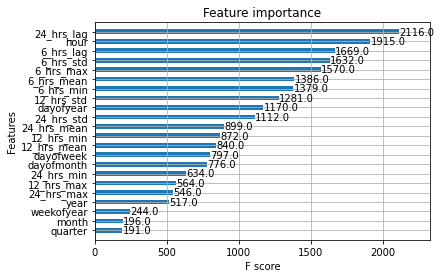

In [27]:
_ = plot_importance(reg, height=0.5)

In [28]:
df_test['MWh_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

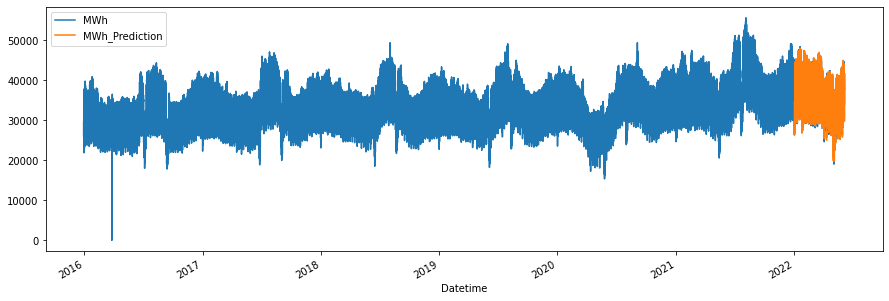

In [29]:
_ = df_all[['MWh','MWh_Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

In [30]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(30)
_ = df_all[['MWh_Prediction','MWh']].plot(ax=ax,
                                              style=['-','*'])
ax.set_xbound(lower='01-01-2022', upper='02-01-2022')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2022 Forecast vs Actuals')

In [31]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(30)
_ = df_all[['MWh_Prediction','MWh']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2022', upper='01-08-2022')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First week of January 2022 Forecast vs Actuals')

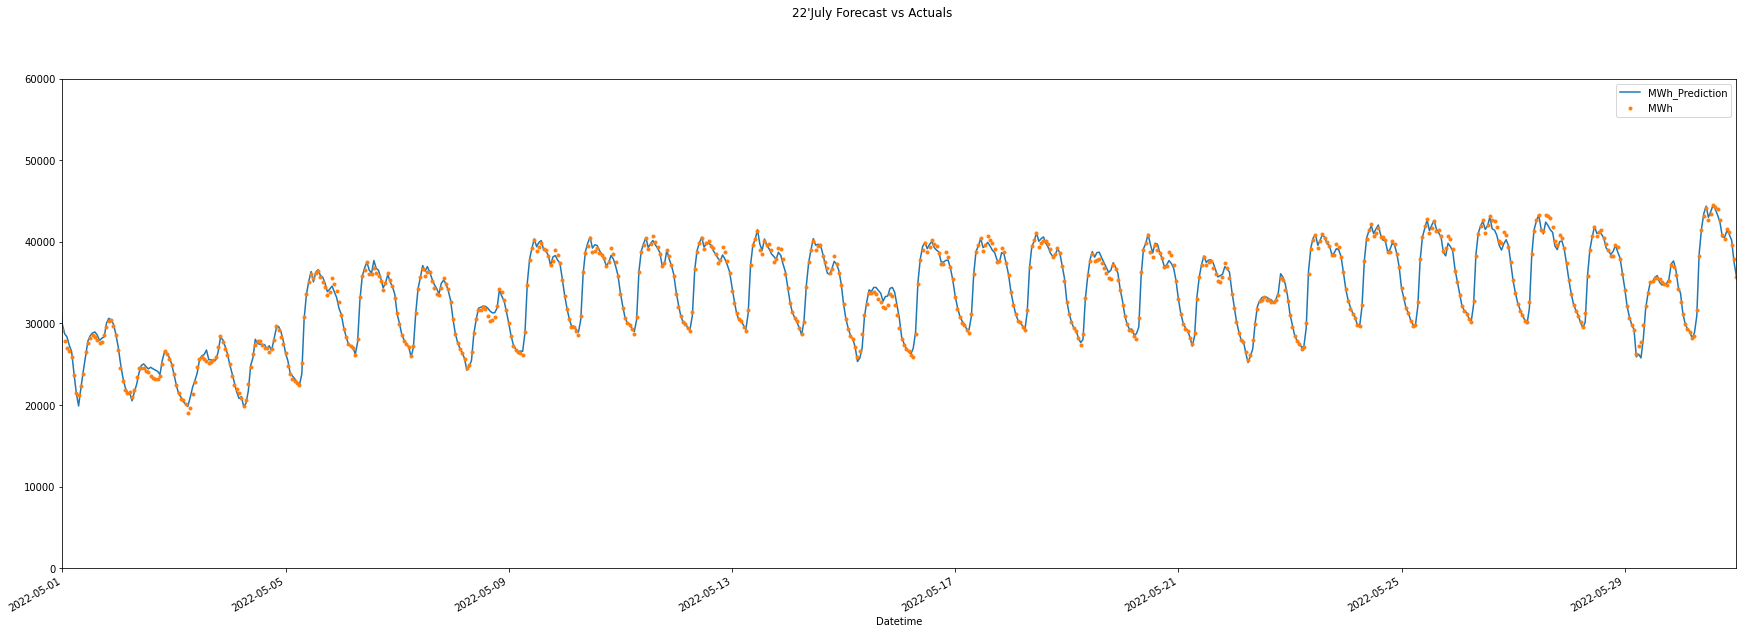

In [32]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(30)
_ = df_all[['MWh_Prediction','MWh']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='05-01-2022', upper='05-31-2022')
plot = plt.suptitle("22'July Forecast vs Actuals")

In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
mean_squared_error(y_true=df_test['MWh'], y_pred=df_test['MWh_Prediction'], squared=False)

436.09304250557756

In [35]:
mean_absolute_error(y_true=df_test['MWh'], y_pred=df_test['MWh_Prediction'])

299.3745572986747

In [36]:
mean_absolute_percentage_error(y_true=df_test['MWh'], y_pred=df_test['MWh_Prediction'])

0.8233924265930231

# Error Metrics:

- RMSE: 436.093
- MAE: 299.37
- MAPE: %0.82

# Look at Worst and Best Predicted Days

In [37]:
df_test['error'] = df_test['MWh'] - df_test['MWh_Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth', "hour"]) \
    .mean()[['MWh','MWh_Prediction','error','abs_error']]

### Over forecasted days

In [38]:
error_by_day.sort_values('error', ascending=True).head(10)

MWh  MWh_Prediction        error    abs_error
year month dayofmonth hour                                                    
2022 6     4          20    34064.91    37974.750000 -3909.840000  3909.840000
     4     17         8     27798.12    30844.689453 -3046.569453  3046.569453
           2          7     28171.93    30873.298828 -2701.368828  2701.368828
     6     4          19    35270.81    37632.636719 -2361.826719  2361.826719
     4     30         23    31238.51    33373.128906 -2134.618906  2134.618906
           3          8     25442.68    27380.009766 -1937.329766  1937.329766
                      9     26997.98    28926.691406 -1928.711406  1928.711406
           23         7     28783.28    30661.384766 -1878.104766  1878.104766
           17         7     26483.51    28298.296875 -1814.786875  1814.786875
           30         22    32944.83    34614.835938 -1670.005937  1670.005937

In [39]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(30)
_ = df_all[['MWh_Prediction','MWh']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='04-17-2022', upper='04-18-2022')
plot = plt.suptitle("One of Worst Predicted Day - 17.04.2022")

### Best predicted days

In [40]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

MWh  MWh_Prediction     error  abs_error
year month dayofmonth hour                                               
2022 1     11         3     31813.60    31813.593750  0.006250   0.006250
     5     14         5     29433.70    29433.623047  0.076953   0.076953
     4     4          0     30370.63    30370.478516  0.151484   0.151484
     5     3          0     23747.27    23747.595703 -0.325703   0.325703
           30         4     28992.34    28991.998047  0.341953   0.341953
     3     18         3     32305.76    32306.183594 -0.423594   0.423594
     4     27         8     36564.36    36563.875000  0.485000   0.485000
     2     8          20    41998.30    41998.792969 -0.492969   0.492969
           22         3     30959.60    30960.150391 -0.550391   0.550391
     4     7          4     32149.13    32148.554688  0.575313   0.575313

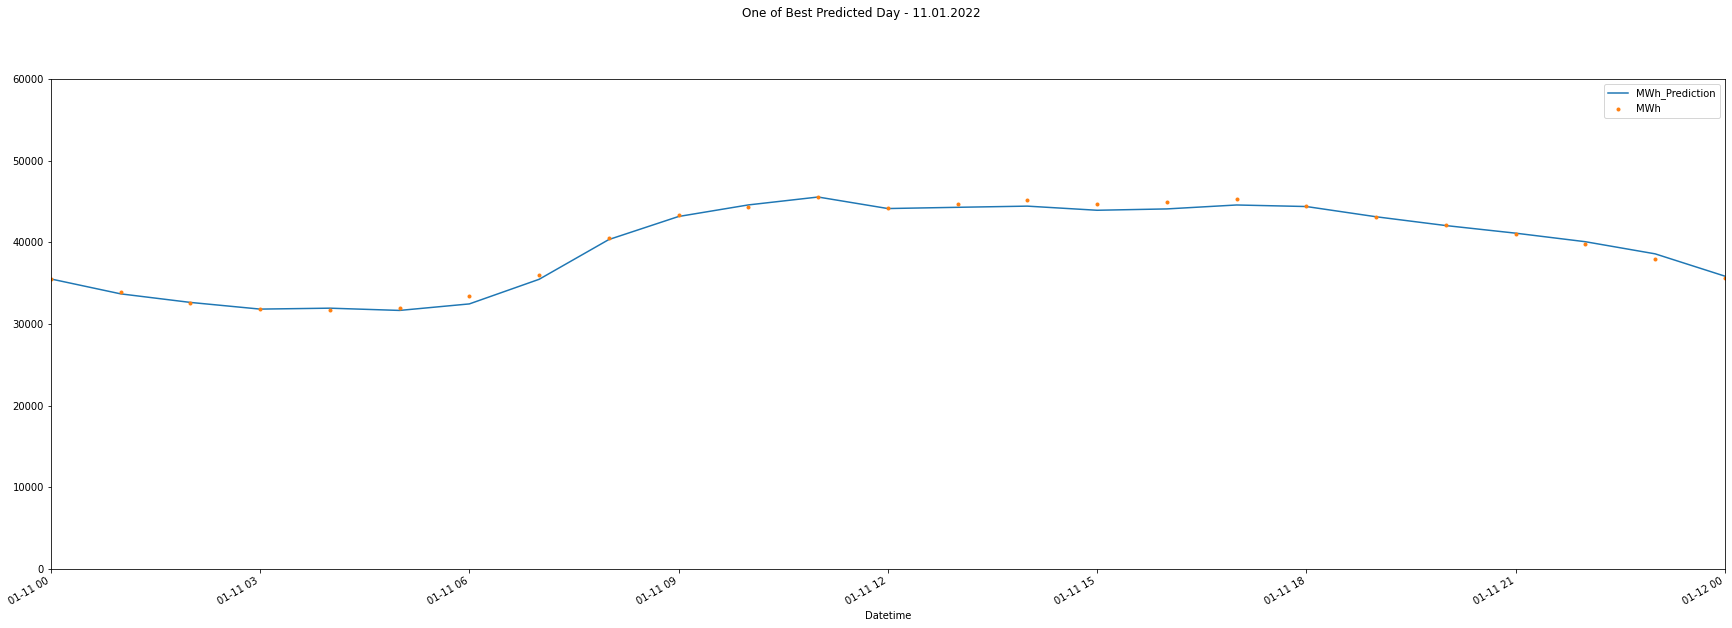

In [41]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(30)
_ = df_all[['MWh_Prediction','MWh']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='01-11-2022', upper='01-12-2022')
plot = plt.suptitle("One of Best Predicted Day - 11.01.2022")

In [42]:
df.head()

MWh                date  hour  dayofweek  quarter  \
Datetime                                                                      
2015-12-31 00:00:00  29590.88 2015-12-31 00:00:00     0          3        4   
2015-12-31 01:00:00  27785.43 2015-12-31 01:00:00     1          3        4   
2015-12-31 02:00:00  26516.53 2015-12-31 02:00:00     2          3        4   
2015-12-31 03:00:00  26091.62 2015-12-31 03:00:00     3          3        4   
2015-12-31 04:00:00  25871.54 2015-12-31 04:00:00     4          3        4   

                     month  year  dayofyear  dayofmonth  weekofyear  ...  \
Datetime                                                             ...   
2015-12-31 00:00:00     12  2015        365          31          53  ...   
2015-12-31 01:00:00     12  2015        365          31          53  ...   
2015-12-31 02:00:00     12  2015        365          31          53  ...   
2015-12-31 03:00:00     12  2015        365          31          53  ...   
2015-12-31 04:00:00     12  2015        365          31          53  ...   

                     6_hrs_std  12_hrs_std  24_hrs_std  6_hrs_max  12_hrs_max  \
Datetime                                                                        
2015-12-31 00:00:00        NaN         NaN         NaN        NaN         NaN   
2015-12-31 01:00:00        NaN         NaN         NaN        NaN         NaN   
2015-12-31 02:00:00        NaN         NaN         NaN        NaN         NaN   
2015-12-31 03:00:00        NaN         NaN         NaN        NaN         NaN   
2015-12-31 04:00:00        NaN         NaN         NaN        NaN         NaN   

                     24_hrs_max  6_hrs_min  12_hrs_min  24_hrs_min  holiday  
Datetime                                                                     
2015-12-31 00:00:00         NaN        NaN         NaN         NaN        0  
2015-12-31 01:00:00         NaN        NaN         NaN         NaN        0  
2015-12-31 02:00:00         NaN        NaN         NaN         NaN        0  
2015-12-31 03:00:00         NaN        NaN         NaN         NaN        0  
2015-12-31 04:00:00         NaN        NaN         NaN         NaN        0  

[5 rows x 26 columns]

In [43]:
df = pd.get_dummies(df, columns=['dayofweek', 'month', 'hour'])

# Hyper Parameter Optimization

In [44]:
########################
# Time-Based Validation Sets
########################

import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# 2022'nin 3.ayına kadar train seti.
train = df.loc[(df.index < "2022-01-01"), :]

# 2022'nin son 3 ayı Date seti.
val = df.loc[(df.index >= "2022-01-01"), :]

cols = [col for col in train.columns if col not in ['date', "MWh"]]

y_train = train['MWh']
X_train = train[cols]

y_val = val['MWh']
X_val = val[cols]

# kontrol
y_train.shape, X_train.shape, y_val.shape, X_val.shape


((52632,), (52632, 64), (3717,), (3717, 64))

In [45]:
import os
import mlflow
import xgboost as xgb
os.environ['MLFLOW_TRACKING_URI'] = 'http://localhost:5000/'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://localhost:9000/'

mlflow.set_experiment("electricity consumption v4")

2022/06/05 08:35:57 INFO mlflow.tracking.fluent: Experiment with name 'electricity consumption v4' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://vbo-mlflow-bucket/6', experiment_id='6', lifecycle_stage='active', name='electricity consumption v4', tags={}>

In [46]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [47]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [48]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mape", mape)

    return {'loss': rmse, 'status': STATUS_OK}

In [49]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[08:36:09] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14479.51758                                             
[1]	validation-rmse:5708.97412                                              
[2]	validation-rmse:2318.65576                                              
[3]	validation-rmse:1065.75659                                              
[4]	validation-rmse:684.32532                                               
[5]	validation-rmse:596.28156                                               
[6]	validation-rmse:579.11920                                               
[7]	validation-rmse:574.88171                                               
[8]	validation-rmse:573.50415                                               
[9]	validation-rmse:572.88440                                               
[10]	validation-rmse:572.77582                                              
[11]	validation-rmse:572.81836    